Including the classes from the lecture. First the potential:

In [1]:
# for simplicity, we define the OBE exchange by numerical integration 
# and add one contact term to be determined using either a bound state or a scattering length 

import numpy as np
import math as m
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre


class OBEpot:
    """Provides a method for the partial wave representation of the OBE potential. 
    
       The matrix elements are obtained by numerical intergration.
       The mass of the exchanged boson, the strength of the 
       interaction and the couter term is given on initialization. 
       The interaction is regularized using a cutoff that is also 
       given on init.
    """
    
    # this are common parameters for all instances 
    hbarc=197.327
    
    # init interaction
    def __init__(self, cutoff=500.0, C0=1.0, nx=12,mpi=138.0,A=-1.0):
        """Defines the one boson exchange for a given regulator, coupling strength and short distance parameter
        
        Parameters:
        cutoff -- regulator in MeV
        C0 -- strength of the short distance counter term (in s-wave) 
        A -- strength of OBE
        nx -- number of angular grid points for numerical integration
        mpi -- mass of exchange boson in MeV"""
        
        self.mpi = mpi/self.hbarc
        self.cutoff = cutoff/self.hbarc
        self.C0=C0
        self.A=A
        self.nx=nx
        
        self.xp=np.empty((self.nx),dtype=np.double)
        self.xw=np.empty((self.nx),dtype=np.double)
        self.xp,self.xw=leggauss(self.nx)
    
    
    
    # function defines the x integral 
    def _g(self,pp,p,k):
        """Calculates g function of the partial wave decomposition of OBE. 
        
           pp -- outgoing momentum 
           p -- incoming momentum
           k -- angular momentum"""
        
        # define prefact 
        # get the corresponding legendre polynomial 
        Pk = legendre(k)
        # define momentum transfer dependent on angles 
        qval=np.sqrt(p**2+pp**2-2*p*pp*self.xp)
        
        # build integral of regularized OBE 
        return float(np.sum(Pk(self.xp)/((qval**2+self.mpi**2))*self.xw*np.exp(-(qval**2+self.mpi**2)/self.cutoff**2)))
        
    # determines complete, regularized interaction     
    def v(self,pp,p,l):
        """Potential matrix element in fm**2
        
           pp -- outgoing momentum in fm**-1
           p -- incoming momentum in fm**-1
           l -- angular momentum""" 
        
        # first overall prefact of 1pi exchange part  (cancel 2pi factors!)
        prefact=self.A
        
        mat=prefact*self._g(pp,p,l)

        if (l==0):   # add s-wave counter term 
          mat+=self.C0*np.exp(-(pp**2+p**2)/self.cutoff**2)  # 4pi is take into account by spherical harmonics for l=0
                    
        return mat

And then the TwoBody class:

In [2]:
import numpy as np 
from numpy.polynomial.legendre import leggauss
from scipy.special import spherical_jn
from scipy.interpolate import interp1d

class TwoBody:
    """Methods to obtain eigenvalues and eigenvectors for the bound state problem and for searches of the binding energy."""
    # define hbarc for unit conversion 
    hbarc=197.327  
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, mred=938.92/2,l=0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0, 
                            np1four=200,np2four=100):
        """Initialization of two-body solver. 
        
           The initialization defines the momentum grids and the interaction and partial wave to be used. 
           At this time, also the grid for Fourier transformation and for the Fourier transformed 
           wave function is given. 
           
           Parameters:
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of grid points in interval [0,pb] 
           np2 -- number of grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           mred -- reduces mass of the two bosons in MeV
           
           nr1 -- number of r points in interval [0,rb] 
           nr2 -- number of r points in interval [rb,rc]
           ra  -- half of np1 points are in interval [0,pa]
           rb  -- interval boundary as defined above 
           rc  -- upper integration boundary for the solution of the integral equation 
           
           np1four -- number of p points in interval [0,pb] for Fourier trafo
           np2four -- number of p points in interval [pb,pc] for Fourier trafo"""
        
        # store parameters (if necessary convert to fm)
        self.np1 = np1
        self.np2 = np2
        self.npoints  = np1+np2 
        self.mred=mred/self.hbarc
        self.pa=pa
        self.pb=pb
        self.pc=pc
        self.l=l 

        self.nr1 = nr1
        self.nr2 = nr2
        self.nrpoints  = nr1+nr2 
        self.ra=ra
        self.rb=rb
        self.rc=rc

        self.np1four = np1four
        self.np2four = np2four
        self.npfour  = np1four+np2four 

        # store grid points and weights for integral equations
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)
 
        # store grid points and weights for r space wave functions
        self.rgrid,self.rweight = self._trns(self.nr1,self.nr2,self.ra,self.rb,self.rc)
        
        # store grid points and weights for Fourier trafo 
        self.pfourgrid,self.pfourweight = self._trns(self.np1four,self.np2four,self.pa,self.pb,self.pc)
        
        # store underlying interaction
        self.pot=pot
        
    def _trns(self,np1,np2,pa,pb,pc):
      """Auxilliary method that provides transformed Gaus-Legendre grid points and integration weights.
      
         This is using a hyperbolic trafo shown in the lecture. 
         Parameter: 
         np1 --  grid points in ]0,pb[
         np2 --  grid points are distributed in ]pb,pc[ using a linear trafo
         
         pa  -- half of np1 points are in interval [0,pa]
         pb  -- interval boundary as defined above 
         pc  -- upper integration boundary """ 
    
      x1grid,x1weight=leggauss(np1)
      x2grid,x2weight=leggauss(np2)

      # trafo (1.+X) / (1./P1-(1./P1-2./P2)*X) for first interval 
      p1grid=(1.+x1grid) / (1./pa-(1./pa-2./pb)*x1grid)
      p1weight=(2.0/pa-2.0/pb)*x1weight / (1./pa-(1./pa-2./pb)*x1grid)**2

      # linear trafo 
      p2grid=(pc+pb)/2.0 + (pc-pb)/2.0*x2grid
      p2weight=(pc-pb)/2.0*x2weight
   
      pgrid=np.empty((self.npoints),dtype=np.double)
      pweight=np.empty((self.npoints),dtype=np.double)
    
      pgrid = np.concatenate((p1grid, p2grid), axis=None)
      pweight = np.concatenate((p1weight, p2weight), axis=None)
   
      return pgrid,pweight 

# set up set of equations and calculate eigenvalues 

    def eigv(self,E,neigv):
      """Solve two-body integral equation and return n-th eigenvalue, momentum grid and wave function. 

         Parameters:
         E -- energy used in the integral equation in fm**-1 
         neigv -- number of the eigenvalue to be used"""
   
    # set up the matrix amat for which eigenvalues have to be calculated 
      amat=np.empty((self.npoints,self.npoints),dtype=np.double)
      for i in range(self.npoints):
        for j in range(self.npoints): 
          amat[i,j]=np.real(1.0/(E-self.pgrid[i]**2/(2*self.mred))*self.pot.v(self.pgrid[i],self.pgrid[j],self.l)*self.pweight[j]*self.pgrid[j]**2)

    # determine eigenvalues using numpy's eig method        
      evalue,evec=np.linalg.eig(amat)
    
    # I now assume that the relevant eigenvalues are real to avoid complex arithmetic 
      evalue=np.real(evalue)
        
    # remove neigv-1 largest eigenvalues 
      for n in range(neigv-1):
        maxpos=np.argmax(evalue)
        evalue[maxpos]=0.0
    
    # take the next one 
      maxpos=np.argmax(evalue)
      eigv=evalue[maxpos]
    # define solution as unnormalized wave function 
      wf=evec[:,maxpos]
    # and normalize 
      norm=np.sum(wf**2*self.pweight[0:self.npoints]*self.pgrid[0:self.npoints]**2)
      wf=1/np.sqrt(norm)*wf
    
      return eigv,self.pgrid[0:self.npoints],wf

    
    def esearch(self,neigv=1,e1=-0.01,e2=-0.0105,elow=0.0,tol=1e-8):
        """Perform search for energy using the secant method. 
        
           Parameters:
           neigv -- number of the eigenvalue to be used
           e1 -- first estimate of binding energy (should be negative)
           e2 -- second estimate of binding energy (should be negative)
           elow -- largest energy to be used in search (should be negative)
           tol -- if two consecutive energies differ by less then tol, the search is converged
           
           Energies are given in fm**-1. """
        
        # determine eigenvalues for starting energies        
        eta1,pgrid,wf=self.eigv(e1,neigv)
        eta2,pgrid,wf=self.eigv(e2,neigv)
        
        while abs(e1-e2) > tol: 
          # get new estimate (taking upper value into account)   
          enew=e2+(e1-e2)/(eta1-eta2)*(1-eta2) 
          enew=min(elow,enew)
       
          # get new eigenvalue and replace e1 and e2 for next iteration
          eta,pgrid,wf=self.eigv(enew,neigv)
          e2=e1
          eta2=eta1
          e1=enew
          eta1=eta 
            
        return e1,eta1,pgrid,wf 
           
    def fourier(self,wfp):
        """Calculates the Fourier transform of the partial wave representation of the wave function.
        
           Parameter: 
           wfp -- wave function in momentum space
            
           Note that the factor I**l is omitted."""
        
        # calculate spherical bessel functions based dense Fourier trafo momentum grid and rgrid
        # prepare matrix based on r,p points  
        rpmat = np.outer(self.rgrid,self.pfourgrid)
        # evaluate jl     
        jlmat = spherical_jn(self.l,rpmat)
        
        # interpolate of wave to denser Fourier trafo grid
        wfinter = interp1d(self.pgrid, wfp, kind='cubic',fill_value="extrapolate")
        # interpolate wf and multiply my p**2*w elementwise 
        wfdense = wfinter(self.pfourgrid)*self.pfourgrid**2*self.pfourweight*np.sqrt(2/m.pi)
        
        # now the Fourier trafo is a matrix-vector multiplication 
        wfr = jlmat.dot(wfdense)
        
        return self.rgrid,wfr
    
    
    def rms(self,wfr):
        """Calculates the norm and rms radius for the given r-space wave function.
        
           Normalization of the wave function is assumed. 
           Parameter: 
           wfr -- wave function in r-space obtained by previous Fourier trafo"""
        
        
        norm=np.sum(wfr**2*self.rweight*self.rgrid**2)
        rms=np.sum(wfr**2*self.rweight*self.rgrid**4)

            
        rms=np.sqrt(rms)
        
        return norm,rms

In [3]:
import numpy as np
import math as m
import pandas as pd
from lmfit.models import ExpressionModel 
from numpy.polynomial.legendre import leggauss
from scipy.special import legendre
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.special import sph_harm
from scipy.special import spherical_jn
from scipy.integrate import simps
from scipy.integrate import quad

# Homework 7 from Richard Baumann





The Lippmann-Schwinger equations have been rewritten into the form 

\begin{equation}
    t_l(p, p')=V_l(p, p')+\int_0^{\infty}dp" \frac{f(p")-f(q)}{q^2-p"^2}+f(q)\int_0^{\infty} dp" \frac{1}{q^2-p"^2}-i \pi \frac{f(q)}{2q}
\end{equation}

This again can be discretized using grid points $p_i $ with $ i \in \left[ 0, ..., N-1\right]$ and the corresponding integration weights $w_i$. This defines a set of matrix elements $t_l(p_i, p_j)$. These matrix elements do not contain the half on shell elements $t_l(q, p_j)$ and $t_l(p_i, q)$ and therfore also not $t_l(q, q)$.

In order to get this matrix elements list of grid points is append with $p_N =q $. Using this gridpoints I can calculate $t_l(q, q)$ = $t_l(p_N, p_N)$.



## 1 Using these grid points, show that the Lippmann-Schwinger equation can be written in the form:



\begin{equation}
    A_{ik}= \left\{
        \begin{array}{ll}
		\delta_{ij} - \frac{2\mu V_{ik}p_k^2}{q^2-p^2_k}w_k, &\text{ for k \uneq N} \\
		\delta_{ij} + \sum^{N-1}_{m=0} \frac{2\mu V_{iN}q^2}{q^2-p^2_m}w_m - \mu q V_{iN} \ln \left( \frac{p_{max}+q}{p_{max}-q} \right) +i\pi \mu q V_{iN},& \text{ for k = N} 
		\end{array}
        \right.
\end{equation}

Where $p_{max}$ is the upper boundary of the integration as used for the discretization.

With 

\begin{equation}
    f(p")=2 \mu V_l(p, p")t_l(p", p')
\end{equation}

The original equation can be rewritten to:

\begin{equation}
    t_l(p, p')=V_l(p, p')+\int_0^{\infty}dp" \frac{f(p")-f(q)}{q^2-p"^2}+f(q)\int_0^{\infty}dp" \frac{1}{q^2-p"^2}-i \pi \frac{f(q)}{2q} \\
    = V_l(p, p')+ \int_0^{\infty}dp" \frac{2\mu p"^2 V_l(p', p") t_l(p', p")-2\mu q^2 V_l(p', q) t_l(q, p)}{q^2-p"^2}+2\mu q^2 V_l(p', q) t_l(q, p) \int_0^{\infty} dp" \frac{1}{q^2-p"^2}-i \pi \frac{2\mu q^2 V_l(p', q) t_l(q, p)}{2q}\\
    = V_l(p, p')+ \int_0^{\infty}dp" \frac{2\mu p"^2 V_l(p', p") t_l(p', p")-2\mu q^2 V_l(p', q) t_l(q, p)}{q^2-p"^2}+2\mu q^2 V_l(p', q) t_l(q, p) \int_0^{\infty} dp" \frac{1}{q^2-p"^2}- \int_0^{\infty} dp" i \pi \frac{\mu q^2 V_l(p', q) t_l(q, p)}{q}\\
\end{equation}


## 2. Implement the discretized form of the Lippmann-Schwinger equation to obtain the onshell matrix element $ t_{NN} $.

For the implementation I can define a class for the T Matrix. For that I will:

* Generate a momentum grid with weights
* Calculate the A and V matrix with the correct potential
* Use a function to solve the Lippmann-Schwinger equation:

\begin{equation}
    A_{ik}t_{kj}=V_{ij}
\end{equation}

With that I will be able to calculate the onshell matrix element $ t_{NN} $.

In [4]:
# next extend the class for twobody to scattering 
from scipy.special import legendre
import cmath

class TwoBodyTMat(TwoBody):
    """This class defines the off-shell t-matrix for a three-body bound state.
    
       The class assumes three identical particles. It also contains the 
       initialization of grid points for the three-body problem. 
    """
    
    def __init__(self, pot, np1=20, np2=10, pa=1.0, pb=5.0, pc=20.0, 
                            nq1=20, nq2=10, qa=1.0, qb=5.0, qc=20.0,
                            nr1=20, nr2=10, ra=1.0, rb=5.0, rc=20.0,
                            lmax=0,mred=938.92,mass=938.92,
                            np1four=200,np2four=100):
        """Initialization of grid points and interaction for the solution of the three-body problem. 
        
           Parameter: 
           pot -- object that defines the potential matrix elements (e.g. of class OBEpot).
           np1 -- number of p grid points in interval [0,pb] 
           np2 -- number of p grid points in interval [pb,pc]
           pa  -- half of np1 points are in interval [0,pa]
           pb  -- interval boundary as defined above 
           pc  -- upper integration boundary for the solution of the integral equation 
           nq1 -- number of q grid points in interval [0,qb] 
           nq2 -- number of q grid points in interval [qb,qc]
           qa  -- half of np1 points are in interval [0,qa]
           qb  -- interval boundary as defined above 
           qc  -- upper integration boundary for the solution of the integral equation 
           mass -- particle mass of the three identical bosons in MeV

           np1four -- number of p or q  points in interval [0,pb] or[0,qb]   for Fourier trafo
           np2four -- number of p or q points in interval [pb,pc] or [qb,qc] for Fourier trafo
           
           lmax  -- maximal two-body angular momentum to be taken into account
           """
        
        
        # first use the TwoBody class to keep the main parameters 
        super().__init__(pot,np1,np2,pa,pb,pc,mass/2,0,nr1,nr2,ra,rb,rc,np1four,np2four)
        self.pot = pot
        # Assigning the number of points in the first and second intervall
        self.np1 = np1
        self.np2 = np2

        # The number of total points is the number of points in each intervall added.
        self.npoints = np1+np2 

        # Assigning the parameters from above
        self.pa=pa
        self.pb=pb
        self.pc=pc

        # The reduced mass is assigned
        self.mred=mred/self.hbarc
        
        # And also lmax
        self.lmax=lmax 

        # Setting up grid points for the p grid, as well as weights
        self.pgrid,self.pweight = self._trns(self.np1,self.np2,self.pa,self.pb,self.pc)

    """
    Calculation of the t matrix
    """
    # Now I want to solve the t-Matrix as defined above in the formula:
    def prep_tmat(self,E):

        # First q is calculated
        q=(2*self.mred*E)**(1/2)
        
        # And appended to the p grid array
        self.pgrid=np.append(self.pgrid, q)
        
        # This changes the total number of grid points, so I 
        # increase the number here. Then I don't have to do it 
        # later in all loops.
        self.npoints = self.npoints + 1
        
        """
        Now it is time to calculate the t-matrix
        """

        # for every l I want to calculate I need a NxN big array to store the 
        # results
        tmat=np.empty((self.lmax+1,self.npoints,self.npoints),dtype=np.double)

        # now I need to solve the Lippmann-Schwinger equation for each etmat and each l =0,..,lmax
        for l in range(self.lmax+1):

            # For calculating the A matrix I first have to initilize it.
            amat=np.zeros(self.npoints * self.npoints).reshape(self.npoints, self.npoints)
            
            # Now I can calculate every grid point in the A matrix, 
            # and because of this I look over all entries
            for i in range(self.npoints):
                for k in range(self.npoints):

                    # Determining the delta function
                    if i==k:
                        delta = 1
                    else:
                        delta = 0  

                    # If k =/= N, calculate 
                    if (k < self.npoints-1):
                        amat[i,k] = delta - (2 * self.mred * self.pot.pot.v(self.pgrid[i],self.pgrid[k],l)*self.pgrid[k]**2 \
                                    / (q**2 - self.pgrid[k]**2) *self.pweight[k])
                    
                    # If k == N, calculate 
                    else:
                        sum=0
                        # This is the summation part of the calculation
                        for m in range(self.npoints-2):
                            sum = sum + 2 * (self.mred * self.pot.pot.v(self.pgrid[i],self.pgrid[self.npoints-1],l)*q**2 / (q**2 - self.pgrid[m]**2)) *self.pweight[m] \
                                      + 1j * np.pi * self.mred * q * self.pot.pot.v(self.pgrid[i],self.pgrid[self.npoints-1],l) \
                                      - self.mred * q * self.pot.pot.v(self.pgrid[i],self.pgrid[self.npoints-1],l) * np.log((self.pgrid[self.npoints-2]+q)/(self.pgrid[self.npoints-2]-q))           
                        amat[i,k] = delta + sum
                
            # Now all what is left is defining the potential matrix: 
            vmat=np.empty((self.npoints,self.npoints),dtype=np.double)
            for i in range(self.npoints):
                for j in range(self.npoints):   
                    vmat[i,j]=self.pot.pot.v(self.pgrid[i],self.pgrid[j],l)
                
            # Finally I can solve A*t=V. This function returns the tmatrix.
            tmat[l]=np.linalg.solve(amat,vmat)
            
        # And with that I can return the tmatrix with the onshell 
        # and the offshell matrix elements. (tmatrix is NxN big and 
        # contains t_l(q, q))
        return tmat

    """
    Calculation of the t matrix for p_max->inf
    """
    # Now I want to solve the t-Matrix as defined above in the formula:
    def prep_tmat_pmax_inf(self,E):

        # First q is calculated
        q=(2*self.mred*E)**(1/2)
        
        # And appended to the p grid array
        self.pgrid=np.append(self.pgrid, q)
        
        # This changes the total number of grid points, so I 
        # increase the number here. Then I don't have to do it 
        # later in all loops.
        self.npoints = self.npoints + 1
        
        """
        Now it is time to calculate the t-matrix
        """

        # for every l I want to calculate I need a NxN big array to store the 
        # results
        tmat=np.empty((self.lmax+1,self.npoints,self.npoints),dtype=np.double)

        # now I need to solve the Lippmann-Schwinger equation for each etmat and each l =0,..,lmax
        for l in range(self.lmax+1):

            # For calculating the A matrix I first have to initilize it.
            amat=np.zeros(self.npoints * self.npoints).reshape(self.npoints, self.npoints)
            
            # Now I can calculate every grid point in the A matrix, 
            # and because of this I look over all entries
            for i in range(self.npoints):
                for k in range(self.npoints):

                    # Determining the delta function
                    if i==k:
                        delta = 1
                    else:
                        delta = 0  

                    # If k =/= N, calculate 
                    if (k < self.npoints-1):
                        amat[i,k] = delta - (2 * self.mred * self.pot.pot.v(self.pgrid[i],self.pgrid[k],l)*self.pgrid[k]**2 \
                                    / (q**2 - self.pgrid[k]**2) *self.pweight[k])
                    
                    # If k == N, calculate 
                    else:
                        sum=0
                        # This is the summation part of the calculation
                        for m in range(self.npoints-2):
                            sum = sum + 2 * (self.mred * self.pot.pot.v(self.pgrid[i],self.pgrid[self.npoints-1],l)*q**2 / (q**2 - self.pgrid[m]**2)) *self.pweight[m] \
                                      + 1j * np.pi * self.mred * q * self.pot.pot.v(self.pgrid[i],self.pgrid[self.npoints-1],l)           
                        amat[i,k] = delta + sum
                
            # Now all what is left is defining the potential matrix: 
            vmat=np.empty((self.npoints,self.npoints),dtype=np.double)
            for i in range(self.npoints):
                for j in range(self.npoints):   
                    vmat[i,j]=self.pot.pot.v(self.pgrid[i],self.pgrid[j],l)
                
            # Finally I can solve A*t=V. This function returns the tmatrix.
            tmat[l]=np.linalg.solve(amat,vmat)
            
        # And with that I can return the tmatrix with the onshell 
        # and the offshell matrix elements. (tmatrix is NxN big and 
        # contains t_l(q, q))
        return tmat

In [5]:
def t_N_N(lower_p, upper_p, points, Energy):

    # Setting up the relevant parameters.
    c_0 = 2.470795E-02
    lamda = 800

    # Determining the potential, and two body parameters.
    potential=OBEpot(nx=24,mpi=138.0,C0=c_0,A=-1.0/6.474860194946856,cutoff=lamda)
    system=TwoBody(pot=potential,np1=int(points/2),np2=int(points/2),pa=1,pb=lower_p,pc=upper_p,mred=938.92,l=0,
                        nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                        np1four=400,np2four=200)

    # Based on that I set up the t Matrix
    tmat=TwoBodyTMat(system, np1=int(points/2),np2=int(points/2),pa=1,pb=lower_p,pc=upper_p,mred=938.92) #(upper_p+lower_p)/2

    # And calculate 
    element=tmat.prep_tmat(Energy)[0][tmat.npoints-1][tmat.npoints-1]
    return(element)

print(t_N_N(1., 100., 50., -2.225))

-0.0003113532634330139


The algorithm seems to be doing something, but I have now way of verifying that the result is correct.

## 3: By variations of the number of grid points and the upper bound of integration $ p_{max} $, quantify the numerical accuracy of your result for $ t_0(q, q) $ for E = 1 MeV. The contribution $ A_{ik} $ includes a term that vanishes for $ p_{max} \rightarrow \infty $ . Neglect this term and vary $ p_{max} $ again. What do you observe? Why is the behavior different in this case?

First I can take a look at the difference, the number of points makes: For that I calculate the matrix element $t_l(q, q)$ for 

* E= 1 MeV 
* Number of grid points $ \in \left[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 31, 41, 51, 61, 71, 81, 91, 101, 201, 301, 401, 501, 601, 701, 801, 901 \right]$
* $p_{max} \in \left[ 20, 30, 40, 50, 60, 70, 80, 90\right]$

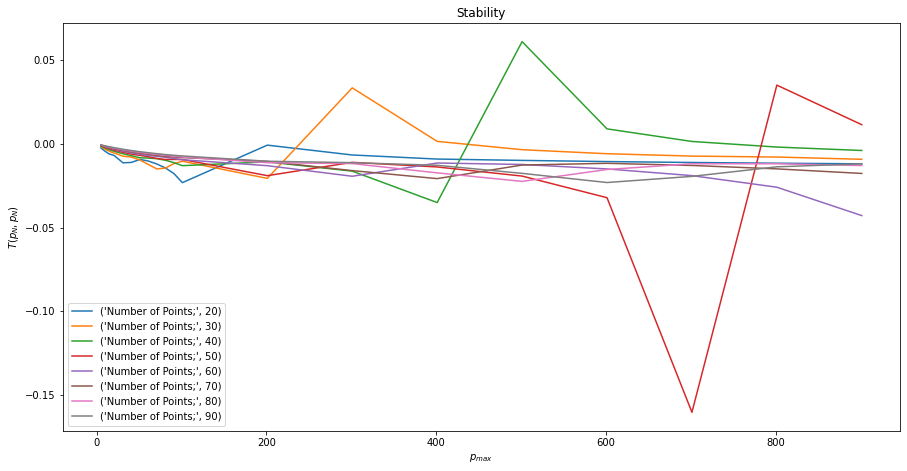

In [6]:
def p_test():
    points_array=np.arange(20, 100, 10)
    p_max_array=np.append(np.append(np.arange(3, 20, 2), np.arange(21, 100, 10)), np.arange(101, 1000, 100))
    t_l_l_array=np.zeros(len(p_max_array)*len(points_array)).reshape(len(points_array), len(p_max_array))

    for j in range(len(points_array)):
        
        for i in range(len(p_max_array)):
            t_l_l_array[j][i]=t_N_N(1, p_max_array[i], points_array[j], 1)
    
    plt.figure(figsize=(15,7.5))
    for j in range(len(points_array)):
        plt.plot(p_max_array, t_l_l_array[j], label=("Number of Points;", points_array[j]))
    plt.legend(loc="best")
    plt.xlabel(r"$p_{max}$")
    plt.ylabel(r"$T(p_N, p_N)$")
    plt.title("Stability")
    plt.savefig("pictures/stability.png", dpi=300)

p_test()

It can be seen, that the number of grid points has a great influence on the stability of the matrix element. Starting at 60-70 points the simulation for the matrix element seems to be stable. The computation times goes up a lot with increasing number of points. Therefore 60 points will be used from now on since this value seems to combine stability and low computation time.

Now, if I look at the term for $ A_{ik} $:

\begin{equation}
    A_{ik}= \left\{
        \begin{array}{ll}
		\delta_{ij} - \frac{2\mu V_{ik}p_k^2}{q^2-p^2_k}w_k, &\text{ for k \uneq N} \\
		\delta_{ij} + \sum^{N-1}_{m=0} \frac{2\mu V_{iN}q^2}{q^2-p^2_m}w_m - \mu q V_{iN} \ln \left( \frac{p_{max}+q}{p_{max}-q} \right) +i\pi \mu q V_{iN},& \text{ for k = N} 
		\end{array}
        \right.
\end{equation}

I can see, that only one term is depended on $ p_{max} $:

\begin{equation}
   lim_{p_{max} \rightarrow \infty} \text{  }\mu q V_{iN} \ln \left( \frac{p_{max}+q}{p_{max}-q} \right) = \mu q V_{iN} \ln(1) = 0
\end{equation}

Therefore $ A_{ik} $ becomes:

\begin{equation}
    A_{ik\text{ , }p_{max}}= \left\{
        \begin{array}{ll}
		\delta_{ij} - \frac{2\mu V_{ik}p_k^2}{q^2-p^2_k}w_k, &\text{ for k \uneq N} \\
		\delta_{ij} + \sum^{N-1}_{m=0} \frac{2\mu V_{iN}q^2}{q^2-p^2_m}w_m +i\pi \mu q V_{iN},& \text{ for k = N} 
		\end{array}
        \right.
\end{equation}

This has already been implemented in the t-Matrix class above. Therefore I will try out, if the two methods of computing $t_l(q, q)$ are similar at high momenta.

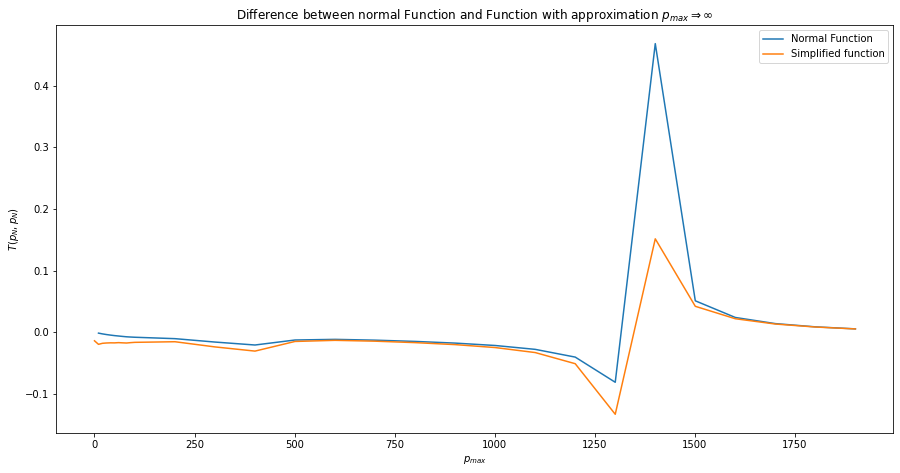

In [7]:
# Function for getting the matrix element for p_max -> inf 
# (Identical to above only with different calculation for the 
# matrix element)
def t_N_N_p_max(lower_p, upper_p, points, Energy):

    # Setting up the relevant parameters.
    c_0 = 2.470795E-02
    lamda = 800

    # Determining the potential, and two body parameters.
    pot=OBEpot(nx=24,mpi=138.0,C0=c_0,A=-1.0/6.474860194946856,cutoff=lamda)
    system=TwoBody(pot=pot,np1=int(points/2),np2=int(points/2),pa=1,pb=lower_p,pc=upper_p,mred=938.92,l=0,
                        nr1=40, nr2=20, ra=1.0, rb=5.0, rc=20.0, 
                        np1four=400,np2four=200)

    # Here the Matrix element is calculated again, but with the routine that looks at p_max->inf
    tmat=TwoBodyTMat(system,np1=int(points/2),np2=int(points/2),pa=1,pb=lower_p,pc=upper_p,mred=938.92) #(upper_p+lower_p)/2

    # And calculate 
    element=tmat.prep_tmat_pmax_inf(Energy)[0][tmat.npoints-1][tmat.npoints-1]
    return(element)

def agreeance_for_p_max(points=70):
    p_max_array=np.append(np.arange(0, 100, 10), np.arange(101, 2000, 100))
    t_l_l_array=np.zeros(len(p_max_array))
    t_l_l_array_p_max_inf=np.zeros(len(p_max_array))

    for i in range(len(p_max_array)):
        t_l_l_array[i]=t_N_N(1, p_max_array[i], points, 1)
        t_l_l_array_p_max_inf[i]=t_N_N_p_max(1, p_max_array[i], points, 1)

    plt.figure(figsize=(15,7.5))
    plt.plot(p_max_array, t_l_l_array, label="Normal Function")
    plt.plot(p_max_array, t_l_l_array_p_max_inf, label="Simplified function")
    plt.legend(loc="best")
    plt.xlabel(r"$p_{max}$")
    plt.ylabel(r"$T(p_N, p_N)$")
    plt.title(r"Difference between normal Function and Function with approximation $p_{max} \Rightarrow \infty$")
    plt.savefig("pictures/difference_function_approximation.png", dpi=300)

agreeance_for_p_max()

## 4: The partial wave decomposed $ S_l(q) = 1 − 2\pi i \mu qt_l(q, q) $ fulfills the unitarity relation |S_l(q)| = 1. Check that your code reproduces this property for l = 0 and selected q. Because of this property, the S- (and t)-matrix can be represented in terms of a real phase shift $\delta _l(q)$. 

\begin{equation}
    S_l(q) = exp (i2\delta_l(q))
\end{equation}

Note that changing $ \delta $ by 180 deg does not change $S_l$ use this feature to plot $ \delta_l $for l = 0 in the range E = 0 . . . 200 MeV such that the function is continues and approaches zero at large E.

## 5: The differential cross section is given by

\begin{equation}
    \frac{d\sigma}{d\hat{q}_f}=(2\pi)^4 \mu ^2 |t(\vec{q}_f, \vec{q}_i)|^2
\end{equation}

Use the relation:

\begin{equation}
    \frac{4\pi}{2l+1}\sum_m Y^*_{lm}(\hat{q}_f) Y_{lm}(\hat{q}_i) =P_l(\hat{q}_f* \hat{q}_i)
\end{equation}

to express the differential cross section as a sum of partial waves. The differential cross section then only depends the polar angle $ \cos \theta = \hat{q}_f \cdot \hat{q}_i $. Plot the differential cross section depending on $ \theta $ for E = 10 MeV. Compare results for summing up to l = 0, 1, 2, 3, 4, 5, 6.

First we can see:

\begin{equation}
    |t(\vec{q}_f, \vec{q}_i)|^2
\end{equation}